# Read QChem output file

In [1]:
import numpy as np
import re
# import for plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sgdml.utils import io
from sgdml.predict import GDMLPredict
from sgdml.utils import io, ui

## Functions

In [2]:
def MDStep(file_name):
    # Some regex expressions
    num_str = re.compile('[+-]?\d+\.?\d*') # to find numbers
    time=re.compile(r'Time\s\(fs\)\s+(\d+\.\d+)')
    findforce=re.compile(r'Forces \(Hartrees\/Bohr\)')
    timestep = re.compile(r'TIME STEP #(\d+)\s\(t = (d\.\d+)\sa.u.\s=\s(d+\.\d+)')
    coord=re.compile(r'X=\s+([-]?\d\.\d+)D([+-]+\d+)\sY=\s+([-]?\d\.\d+)D([+-]+\d+)\sZ=\s+([-]?\d\.\d+)D([+-]+\d+)')
    endcoord=re.compile(r'MW cartesian velocity\:')
    #######
    temp = []
    time = []
    energy = []
    crd = [] # store coordinates in 2D array
    atoms = []
    grad = []
    s = 1.0
    step = 0
    startdyn = 0
    with open(file_name, 'r') as Qfile:
        data=Qfile.readlines()
    for i in range(len(data)):
        # TIME STEP #1 (t = 0.000 a.u. = 0.00000 fs)
        if i==8:
             print(i,data[i])
        if re.search(r'TIME STEP #',data[i]):
            fsec = float(re.findall(r'=\s(\d+\.\d+)\sfs',data[i])[0])
            time.append(fsec)
            startdyn = 1
            # Instantaneous Temperature = 291.9 K
        if re.search(r'Instantaneous Temperature =',data[i]):
            temperature = float(re.findall(r'=\s(\d+\.\d+)\sK',data[i])[0])
            temp.append(temperature)
            i+=1 # Move forward to coordinates
            #    1      O       1.3875858765     0.0114645102     0.1090411228
            #    2      H       1.7395762231     0.7248323964    -0.4529874171
            #    3      H       1.7383622270    -0.7920238234    -0.2840530212
            cols = []
            a = []
            i+=4 # skip forward to geometry
            while re.search(r'----',data[i]) is None: 
                atom = re.findall(r'\s([A-Z])\s',data[i])
                a.append(atom)
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:3]))))                
                i+=1
            crd.append(cols)
            natom = len(a)
            atoms.append(a)
        
        ## Find energy
        if startdyn and re.search(r'Total energy in the final basis set = ',data[i]):
            total_energy = float(re.findall(r'=\s+([-]?\d+\.\d+)',data[i])[0])
            energy.append(total_energy)
        if startdyn and re.search(r'Gradient of SCF Energy',data[i]):
            cols=[]
            i+=2
            # print("Found gradient...", data[i])
            # Gradient of SCF Energy
            # 1           2           3           4           5
            # 1  -0.0238419   0.1260465  -0.0760941  -0.0128590  -0.0132516
            # 2   0.0486590  -0.0115856  -0.0462774   0.0210580  -0.0118539
            #  3  -0.0000008  -0.0000069  -0.0000101   0.0000170   0.0000008
            # Max gradient component =       1.260E-01
            # print('Number of atoms: ',natom)
            while re.search(r'Max gradient component',data[i]) is None: 
                sx=re.findall(r'([-]?\d\.\d+)\s+',data[i])
                cols.append(list(s*(1.0) for s in list(map(float, sx[0:natom]))))                
                i+=1
            gradcomp = []
            # print(cols)
            for i in np.arange(natom):
                gradcomp.append([cols[0][i],cols[1][i],cols[2][i]])
            # print(gradcomp) # Checks out, correct atoms and x, y, z components
            grad.append(gradcomp)
    print("Completed read of file\n Coordinates, time(fsec), temperature(K), energy(Hartree) returned...")
    
    sR = np.array(crd)
    energy = energy[:]
    time = time[1:]
    gradarr = np.array(grad)
    gradx = gradarr[:,0,0]
    print(np.asarray(time).shape, np.asarray(energy).shape)
    print(np.asarray(grad).shape, np.asarray(gradx).shape)
    ## Plot energy ##
    zero_energy = np.array(energy) - min(np.array(energy))
    plt.scatter(time,zero_energy)
    plt.tight_layout()
    plt.xlabel("time [fsec]")
    plt.ylabel("energy [Hartree]")
    plt.title(file_name+"(QChem)")
    plt.savefig(file_name+".png",dpi=300, bbox_inches = "tight")
    ## Plot gradient ##
    plt.scatter(time,gradx)
    plt.tight_layout()
    plt.xlabel("time [fsec]")
    plt.ylabel("x gradient [Hartree]/Bohr")
    plt.title(file_name+" Gradient (QChem)")
    plt.savefig(file_name+"_gradient.png",dpi=300, bbox_inches = "tight")
    ## return ##
    
    return sR,time,temp,energy, grad, atoms

### extended xyz format write 
File to be used for training of sGDML 
<div class="alert alert-block alert-info"> Below is an example of an extended xyz file:
</div>
<code>
9
-97088.53328354699
C	-0.019177078255	0.565281506616	-0.017707166769	0.00  0.00 0.00
C	-1.322541010044	-0.257863017132	0.021104784603	0.00  0.00 0.00
O	1.20740778407	-0.240470008061	0.052343885974	0.00  0.00 0.00
H	0.112915342493	1.272309700543	-0.830045235762	0.00  0.00 0.00
H	0.158814392784	1.116626422051	0.869682199341	0.00  0.00 0.00
H	-1.087634829566	-1.149513478699	0.663030580516	0.00  0.00 0.00
H	-2.2950373724	0.282895316258	0.198602896473	0.00  0.00 0.00
H	-1.305725447355	-0.565837176562	-1.040260047316	0.00  0.00 0.00
H	1.229837602444	-0.800426536788	-0.732200699668	0.00  0.00 0.00
</code>


In [3]:
def write_exyz(atoms,energy,coord,filename):
    numatoms = np.shape(atoms)[1]
    numsteps = np.shape(atoms)[0]
    f  = open(filename,'w')
    for i in np.arange(numsteps):
        f.write(str(numatoms)+"\n")
        f.write(str(energy[i])+"\n")
        for j in np.arange(numatoms):
            geom = '{0:9.6f} {1:9.6f} {2:9.6f} '.format(coord[i][j][0],coord[i][j][1],coord[i][j][2])
            geom_line = atoms[i][j][0]+"  "+geom+" 0.0000 0.0000 0.0000\n"
            f.write(geom_line)
    return   

### Prepare sGDML arrays

In [4]:
def prep_sgdml(R,atoms,E,F):    
    z=[]
    z.append(io._z_str_to_z_dict[atoms[0]])
    F = np.hstack(F)
    fshape = np.shape(F)
    ts = int(fshape[0]/(n_atoms*3))
    print(fshape)
    factor = -4186*2000/625*0.52*535*1/0.83 # (kcal/mol) J/mol
    print("Factor: ",factor)
    F = F.reshape(-1, n_atoms, 3)* factor #1185.8*2 #43.59 #0.529 #627.5/0.529 #1185.8 # 23.062063375661/0.529 = 43.59 Remove negative sign to shift between gradient and force
    R = np.hstack(R)
    R = R[:fshape[0]] # Limit size of carts to that of forces
    R = R.reshape(-1,n_atoms, 3)
    E = np.array(E[:ts])*627.51 # Limit size of carts to that of forces
    print("Emax: %6.2f Emin: %6.2f" %(np.max(E),np.min(E)))
    Enorm = (E -np.min(E))
    plt.hist(Enorm)
    plt.title("Energy distribution")
    plt.savefig('EDist_h2o_read.png')
    z = np.array(z)
    print("Found", n_atoms," atoms and ",ts," time steps.")
    return (R, z, E, F)

## Data Analysis

#### Read QChem output file

8 output file: 

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...
(2218,) (2218,)
(2218, 5, 3) (2218,)
[['C'], ['O'], ['H'], ['H'], ['H']]


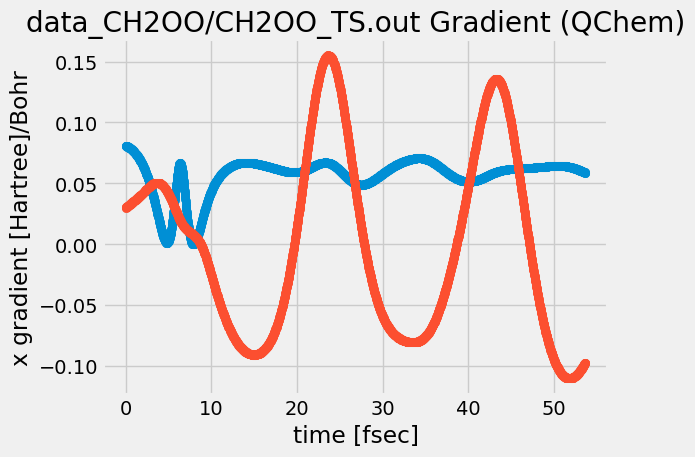

In [5]:
filename='data_CH2OO/CH2OO_TS.out'
coord,time,temp,energy,grad, atoms = MDStep(filename)
print(atoms[0])


In [8]:
io._z_str_to_z_dict[atoms[0][0]]

TypeError: unhashable type: 'list'

In [15]:
for item, z in enumerate(atoms[0]):
    print(z[0])

C
O
H
H
H


In [ ]:
list(s*(1.0) for s in list(map(float, [0:natom])))

In [6]:
R, z, E, F = prep_sgdml(coord, atoms[0],energy,grad) 

TypeError: unhashable type: 'list'

In [ ]:
len(energy), len(time)

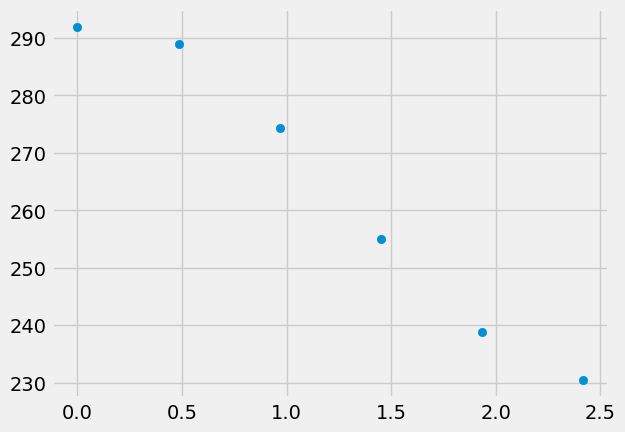

In [108]:
plt.scatter(time,temp)

In [133]:
filename='QChem_waterdimer_output192201.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [134]:
np.shape(energy)

(1000,)

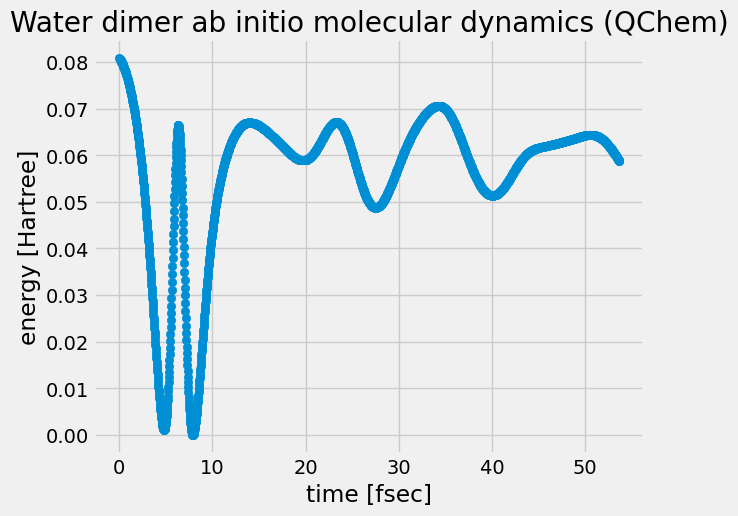

In [57]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Water dimer ab initio molecular dynamics (QChem)")
plt.savefig("energy_water_dimer.png",dpi=300, bbox_inches = "tight")

In [48]:
filename='output192979.txt'
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


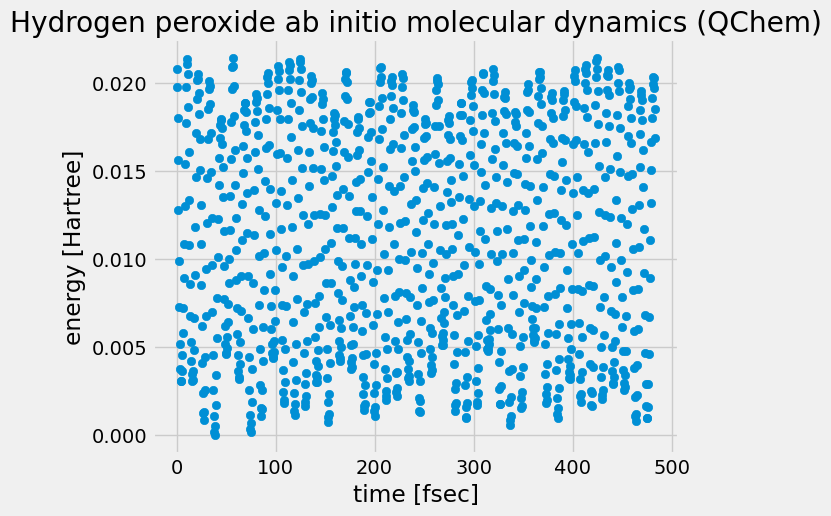

In [49]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("Hydrogen peroxide ab initio molecular dynamics (QChem)")
plt.savefig("energy_peroxide.png",dpi=300, bbox_inches = "tight")

In [63]:
filename = "syn-MVK-oxide-aims.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [1]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo.xyz")

NameError: name 'write_exyz' is not defined

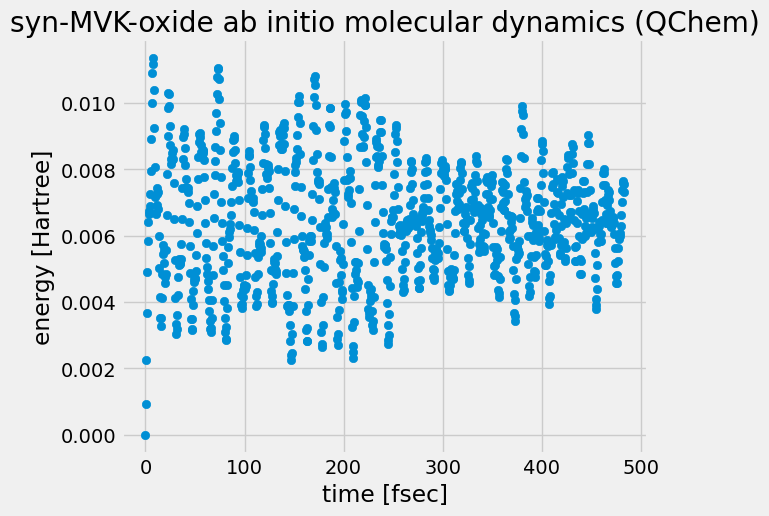

In [16]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem)")
plt.savefig("syn-MVK-oxide.png",dpi=300, bbox_inches = "tight")

### syn-MVK-oxide 1500K


In [5]:
filename = "syn-MVK-oxide-1500K.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8  Q-Chem 6.0, Q-Chem, Inc., Pleasanton, CA (2022)

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


In [8]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo-1500K.xyz")

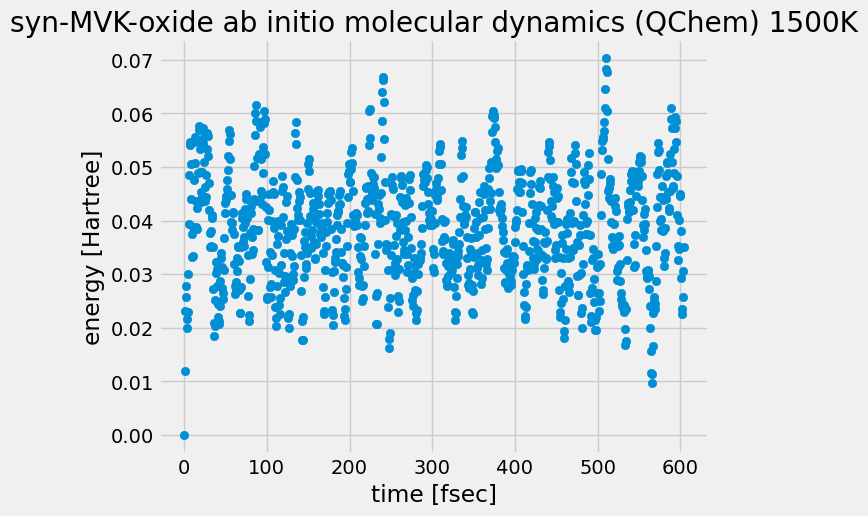

In [7]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem) 1500K")
plt.savefig("syn-MVK-oxide 1500K.png",dpi=300, bbox_inches = "tight")

In [4]:
filename = "syn-MVK-oxide #193121 4000K.txt"
coord,time,temp,energy,atoms = MDStep(filename)

8 

Completed read of file
 Coordinates, time(fsec), temperature(K), energy(Hartree) returned...


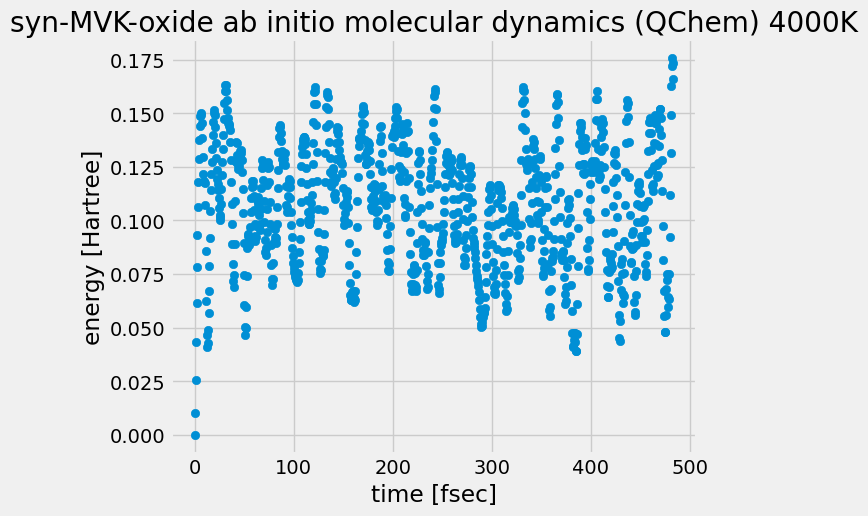

In [5]:
zero_energy = np.array(energy) - min(np.array(energy))
plt.scatter(time,zero_energy)
plt.tight_layout()
plt.xlabel("time [fsec]")
plt.ylabel("energy [Hartree]")
plt.title("syn-MVK-oxide ab initio molecular dynamics (QChem) 4000K")
plt.savefig("syn-MVK-oxide 4000K.png",dpi=300, bbox_inches = "tight")

In [6]:
write_exyz(atoms,energy,coord,"syn-MVK-oxo-4000K.xyz")

In [1]:
ls


 energy_peroxide.png
 energy_water_dimer.png
 ethanol-aims.PBE.TS.light.tier.1-train2000-sym6.npz
 ethanol_ccsd_t-train.xyz
 ethanol_ccsd_t-train.xyz.npz
 ethanol_ccsd_t-train.xyz-unknown-train100-sym6.npz
 ethanol.xyz
 FFT_plot.py*
 IRMDSIM_wl.py*
 MLPES_iPI_PIMD_IR_1.1.py*
 MLPES_MD_IR_MLDIP.py*
 ML_Vibfreq.py*
 molecule.png
 output192979.txt
 QCHEM.py
 QChem_read.ipynb
 qchem_test.txt
 QChem_waterdimer_output192201.txt
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train100-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train200-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem.output-train400-sym/
 sgdml_cv_syn-MVK-oxo-4000K.xyz-QChem-train400-sym/
 sgdml.ipynb
'sgdm-read exyz.ipynb'
'syn-MVK-oxide 1500K.png'
 syn-MVK-oxide-1500K.txt
'syn-MVK-oxide #193121 4000K.txt'
'syn-MVK-oxide 4000K.png'
 syn-MVK-oxide-aims1.png
 syn-MVK-oxide-aims1.txt
 syn-MVK-oxide-aims.txt
 syn-MVK-oxide.png
 syn-MVK-oxide.txt
 syn-MVK-oxo-1500K.xyz
 syn-MVK-oxo-4000K.xyz
 syn-MVK-oxo-4000K.xyz.npz
 syn-MVK-oxo.